## Script to make figure 5: comparison between different source size and integration radii
Generate CBED with different source size then average with different integration radii

In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import scipy.signal
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.transform import rescale, resize, downscale_local_mean
import csv

In [13]:
# Calculate beam level to normalize experiment data
RefPath = '/srv/home/chenyu/DEbackup/033119/C1/'
RefName = 'So'
BeamLevel = 0
rx = 150
ry = 150
AccumulatedFrame = np.zeros((512,512))
for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        BeamLevel = BeamLevel + np.sum(frame)
        AccumulatedFrame = AccumulatedFrame + frame
AccumulatedFrame = AccumulatedFrame / rx / ry
BeamLevel = BeamLevel / rx / ry
print(BeamLevel)

14810322.698989896


59.0


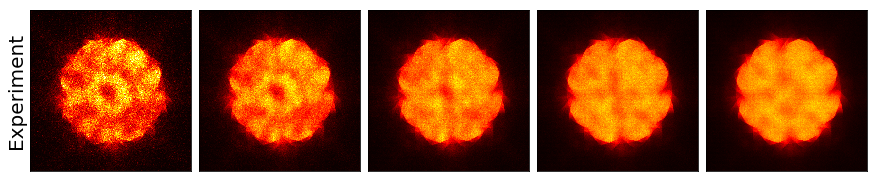

In [4]:
# Plot experiment data with different integration radii
f, axarr = plt.subplots(1, 5, gridspec_kw = {'wspace':0.05, 'hspace':0}, figsize=(15,3))
exp_folder = '/srv/home/chenyu/DEbackup/033119/S8/'
iframe = 23
BeamLevel = 14810322   # Beam level calibrated from blank scan
for i in range(5):
    datacube = np.load(exp_folder + 'PACBED_stack_radius_' + str((i+1)*2) + '.npy')
    im = axarr[i].imshow(datacube[:,:,iframe]/BeamLevel*11.30,cmap='hot',clim=[0,230/BeamLevel*11.30])
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    if i == 0:
        axarr[i].set_ylabel('Experiment', fontsize=20)
       
        
thickness = np.load(exp_folder + 'SrPeaks_thickness.npy')
thickness = thickness[iframe]
# cbar = f.colorbar(im, ax=axarr.ravel().tolist())
print(thickness)   # thickness in unit cells

In [11]:
# Process simulated CBED to get PACBED from different source size and integration radii
path = '/srv/home/chenyu/CNN/Data/STO_50nm/0_0/0.0_0.0mrad/'
base_name = 'depth0_slice20'
base_ext = '_FPavg.npy'
imsize = (np.load(path+base_name+'_X0_Y0'+base_ext)).shape
array_size = (41,41)
out_sz = array_size + imsize

# All different source size and integration radii share the same original dataset
output = np.zeros(out_sz,dtype=np.float32)
for x in range(array_size[0]):
    for y in range(array_size[1]):
        output[x,y,:,:] = np.load(path+base_name+'_X'+str(x)+'_Y'+str(y)+base_ext)
output = np.squeeze(output)
px_size = 17.5

# generate PACBED array to save different PACBEDs
PACBED_array = np.zeros((160,160,36))

for ss in range(6):
    source_size = 1 + ss*30
    sigma = (source_size/px_size)/(2.355)
    kernel = gaussKernel(sigma,array_size[0])
    fkernel = np.fft.fft2(kernel)
    kx,ky = output.shape[2:4]
    # Generate convoluted 4D array
    result = np.zeros(out_sz,dtype=np.float32)
    result = np.squeeze(result)
    for k in range(kx):
        for l in range(ky):
            #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
            result[:,:,k,l] = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(output[:,:,k,l]))).real
            
    for radius in range(5):
        
        integration_radius = (radius+1)*2
        expMask = create_circular_mask(integration_radius*2+1,integration_radius*2+1,center=[integration_radius,integration_radius])
        px_list = np.nonzero(expMask)
        # row for non-zero pixels
        row_list = px_list[0] + 17 - integration_radius
        col_list = px_list[1] + 17 - integration_radius
        PACBED = np.zeros((160,160))

        for i in range(len(row_list)):
            sim = result[row_list[i],col_list[i],164-80:164+80,164-80:164+80]
            sim = sim / 17 # 17 here for phonon configurations
            PACBED = PACBED + sim
    
        PACBED = PACBED / len(row_list) 
        PACBED_array[:,:,ss*6+radius] = PACBED

<function matplotlib.pyplot.show(*args, **kw)>

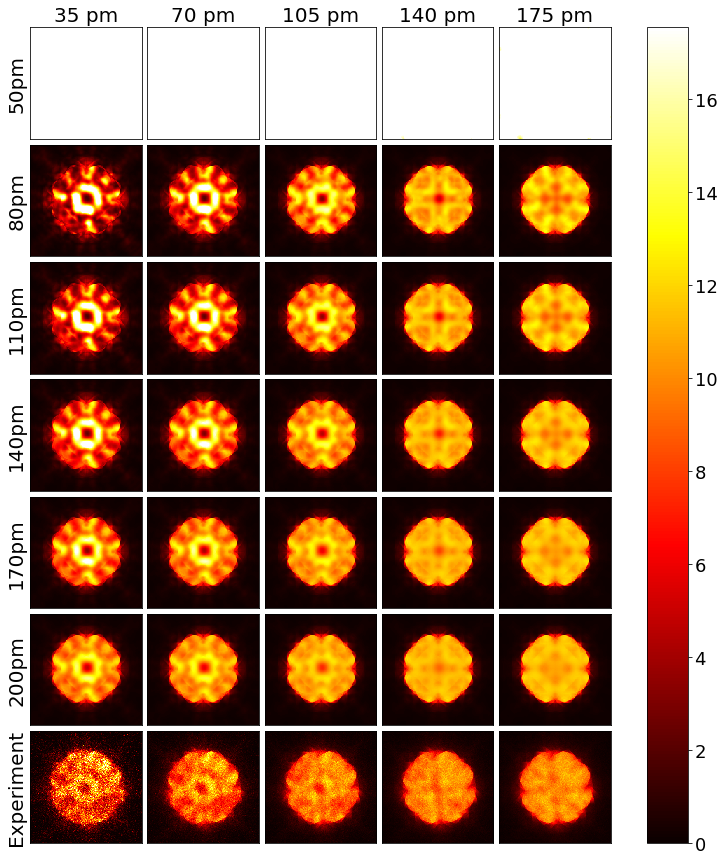

In [12]:
f, axarr = plt.subplots(7, 5, gridspec_kw = {'wspace':0.05, 'hspace':0.05}, figsize=(13,15))
sim_max = PACBED_array.max()
sim_min = PACBED_array.min()
for irow in range(6):
    for icol in range(5):
        im = axarr[irow,icol].imshow(np.transpose(np.fliplr(PACBED_array[:,:,irow*6+icol]*100000)),cmap='hot',clim=[0,230/BeamLevel*11.30*100000])
        axarr[irow,icol].set_xticks([])
        axarr[irow,icol].set_yticks([])
        axarr[irow,icol].set_aspect('equal')
        if irow == 0:
            axarr[irow,icol].set_title(str(int((icol+1)*2*17.5)) + ' pm', fontsize=20)
        if icol == 0:
            axarr[irow,icol].set_ylabel(str(50 + irow*30) + 'pm', fontsize=20)

for icol in range(5):
    datacube = np.load(exp_folder + 'PACBED_stack_radius_' + str(icol*2+1) + '.npy')
    im = axarr[6,icol].imshow(datacube[:,:,iframe]/BeamLevel*11.30*100000,cmap='hot',clim=[0,230/BeamLevel*11.30*100000])
    axarr[6,icol].set_xticks([])
    axarr[6,icol].set_yticks([])
    if icol == 0:
        axarr[6,icol].set_ylabel('Experiment', fontsize=20)
        
cbar = f.colorbar(im, ax=axarr.ravel().tolist())
cbar.ax.tick_params(labelsize=18) 

plt.show

## Find examples of failed prediction in coarse c-CNN at large thickness

57.013000000000005


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


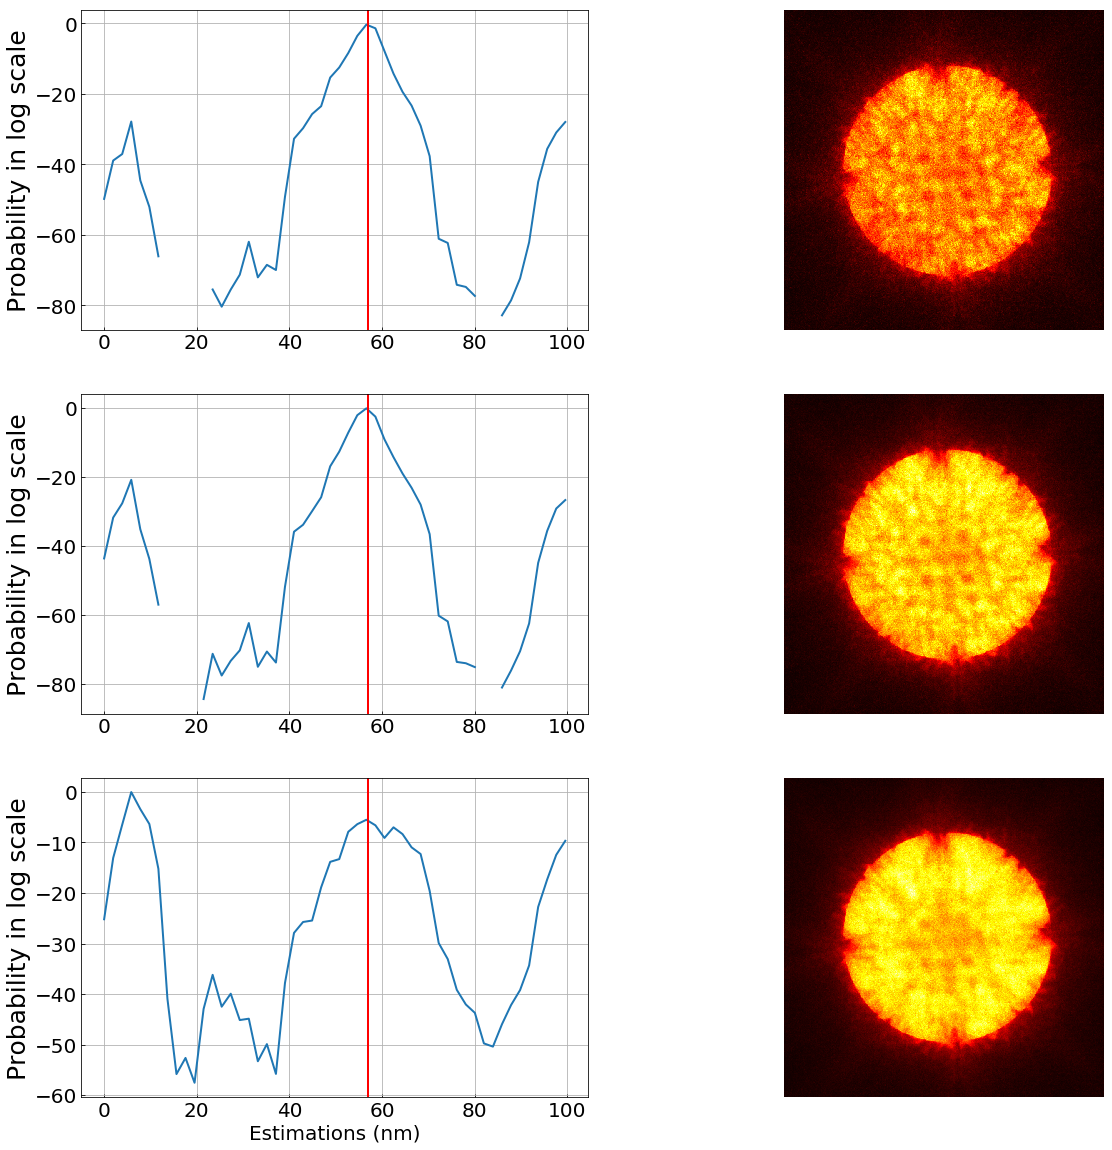

In [351]:
path = '/srv/home/chenyu/DEbackup/033119/S5/'
truth = np.load(path + 'SrPeaks_thickness.npy')
print(truth[0]*0.3905)

fig = plt.figure(figsize=(20,20))
fig.add_subplot(322)
pred = np.load(path + 'prediction_r4_coarse_classification.npy')
exp = np.load(path + 'PACBED_stack_radius_4.npy')
prob = np.load(path + 'prob_r4_coarse_classification.npy')
plt.imshow(exp[:,:,0]/np.max(exp[:,:,0]),cmap='hot')
plt.axis('off')

fig.add_subplot(321)
plt.plot(0.3905*2.5*np.linspace(0,102,52),np.log(prob[0]),linewidth = 2)
plt.axvline(x=truth[0]*0.3905,linewidth=2,color='r')
plt.tick_params(direction='in',labelsize=20)
plt.ylabel('Probability in log scale',fontsize=25)
plt.grid('on')

fig.add_subplot(324)
pred = np.load(path + 'prediction_r6_coarse_classification.npy')
exp = np.load(path + 'PACBED_stack_radius_6.npy')
prob = np.load(path + 'prob_r6_coarse_classification.npy')
plt.imshow(exp[:,:,0]/np.max(exp[:,:,0]),cmap='hot')
plt.axis('off')

fig.add_subplot(323)
plt.plot(0.3905*2.5*np.linspace(0,102,52),np.log(prob[0]),linewidth = 2)
plt.axvline(x=truth[0]*0.3905,linewidth=2,color='r')
plt.tick_params(direction='in',labelsize=20)
plt.ylabel('Probability in log scale',fontsize=25)
plt.grid('on')

fig.add_subplot(326)
pred = np.load(path + 'prediction_r8_coarse_classification.npy')
exp = np.load(path + 'PACBED_stack_radius_8.npy')
prob = np.load(path + 'prob_r8_coarse_classification.npy')
plt.imshow(exp[:,:,0]/np.max(exp[:,:,0]),cmap='hot')
plt.axis('off')

fig.add_subplot(325)
plt.plot(0.3905*2.5*np.linspace(0,102,52),np.log(prob[0]),linewidth = 2)
plt.axvline(x=truth[0]*0.3905,linewidth=2,color='r')
plt.tick_params(direction='in',labelsize=20)
plt.ylabel('Probability in log scale',fontsize=25)
plt.xlabel('Estimations (nm)',fontsize=20)
plt.grid('on')

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


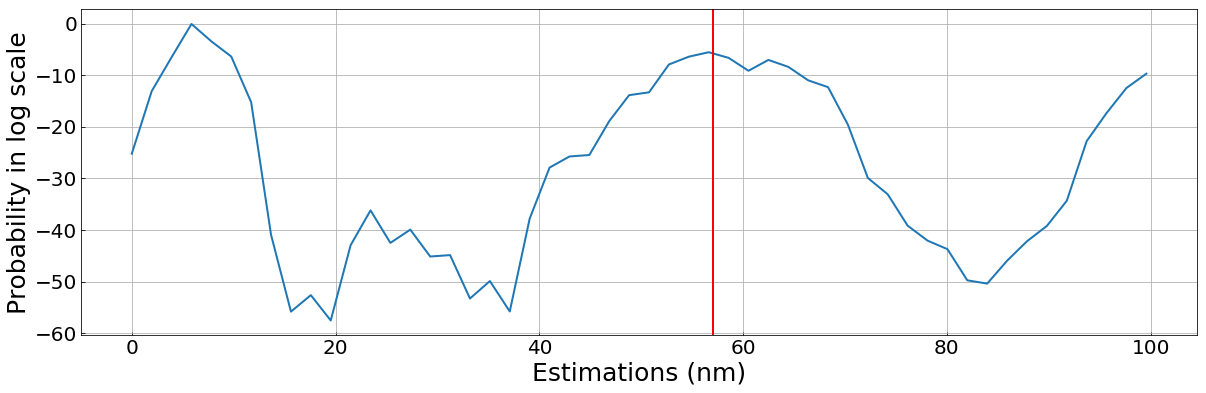

In [366]:
fig = plt.figure(figsize=(20,6))
plt.plot(0.3905*2.5*np.linspace(0,102,52),np.log(prob[0]),linewidth = 2)
plt.axvline(x=truth[0]*0.3905,linewidth=2,color='r')
plt.tick_params(direction='in',labelsize=20)
plt.ylabel('Probability in log scale',fontsize=25)
plt.xlabel('Estimations (nm)',fontsize=25)
plt.grid('on')

(-0.5, 159.5, 159.5, -0.5)

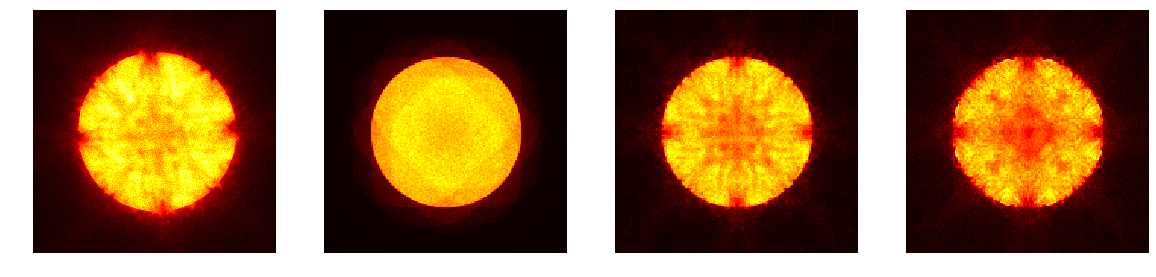

In [362]:
PACBED_path = '/srv/home/chenyu/CNN/Data/STO_100nm_PACBED/0_0/'
fig = plt.figure(figsize=(20,6))

fig.add_subplot(141)
exp = np.load(path + 'PACBED_stack_radius_8.npy')
plt.imshow(exp[:,:,0]/np.max(exp[:,:,0]),cmap='hot')
plt.axis('off')

fig.add_subplot(142)
exp = np.load(PACBED_path + 'STO_2_0_0_8.npy')
plt.imshow(exp,cmap='hot',clim=[0,np.amax(exp)*1.2])
plt.axis('off')

fig.add_subplot(143)
exp = np.load(PACBED_path + 'STO_28_0_0_8.npy')
plt.imshow(exp,cmap='hot',clim=[0,np.amax(exp)*1.2])
plt.axis('off')

fig.add_subplot(144)
exp = np.load(PACBED_path + 'STO_49_0_0_8.npy')
plt.imshow(exp,cmap='hot',clim=[0,np.amax(exp)*1.2])
plt.axis('off')

In [388]:
path = '/srv/home/chenyu/DEbackup/061619/S1/npy/'
PACBED = np.zeros((512,512))
for ix in range(150):
    for iy in range(150):
        filenum = ix*rx+iy+1
        frame = np.load(path+'S1_'+format(filenum,'05')+'.npy')
        PACBED = PACBED + frame

(-0.5, 511.5, 511.5, -0.5)

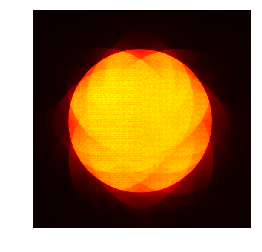

In [395]:
plt.imshow(PACBED,cmap='hot',clim=[0,np.amax(PACBED)*1.3])
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

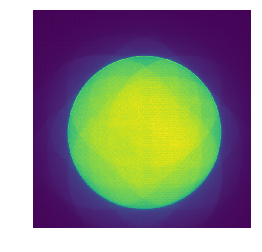

In [408]:
exp = np.load('/srv/home/chenyu/DEbackup/2018/112518/S5/PACBED.npy')
# plt.imshow(exp[:,:,10],cmap='hot')
plt.imshow(exp)
plt.axis('off')

[9.372  7.81   7.81   8.591  8.9815 8.9815 8.9815 8.9815 8.9815 8.9815
 8.591  8.9815 8.591  8.591  8.2005 8.591  8.591  8.591  8.591  8.9815
 8.2005 8.2005 8.591  8.9815 9.372  8.9815 8.9815 8.9815 8.9815 9.7625
 9.372  8.9815 9.372  8.9815 8.2005 8.591  8.9815 8.9815 8.9815 8.591
 8.2005 8.9815 9.372  8.9815 8.9815 9.7625 8.9815 8.9815 8.591  8.591
 8.9815 8.591  8.591  8.591  8.591  8.9815 8.591  8.9815 8.9815 8.9815
 8.9815 8.2005 8.591  9.372  8.591  9.372  8.591  8.9815 9.372  9.372
 8.9815 9.372  8.9815 8.9815]
[9.155939  9.034333  9.061119  8.953579  9.15988   9.026458  8.876883
 9.144816  8.72007   8.407193  8.527927  8.492999  8.801524  8.742316
 8.996601  9.01899   8.695355  8.698638  8.473731  8.4893875 8.35686
 9.045167  8.710524  8.496539  8.923226  8.407684  9.032685  8.984064
 8.280692  9.067985  9.341943  8.530179  8.842546  8.793136  8.626036
 9.02655   8.979427  9.323171  8.90344   9.000558  8.859485  8.948778
 9.021912  9.146478  9.110846  9.301696  9.293508  9.3239

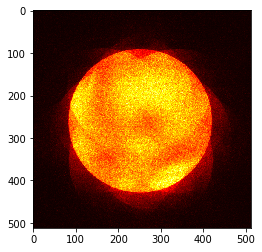

In [387]:
path = '/srv/home/chenyu/DEbackup/061619/S1/'
truth = np.load(path + 'SrPeaks_thickness.npy')
pred = np.load(path + 'prediction_r4_coarse_regression.npy')
exp = np.load(path + 'PACBED_stack_radius_4.npy')
exp = exp[:,:,5]
plt.imshow(exp,cmap='hot')
print(truth*0.3905)
print(pred)

In [7]:
def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

In [8]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

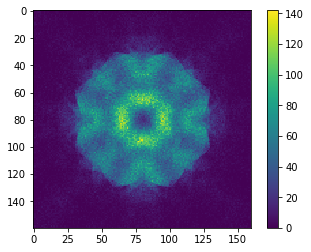

In [246]:
temp = np.load('/srv/home/chenyu/CNN/Data/STO_50nm_PACBED/0_0/STO_20_1_1_3.npy')
plt.imshow(temp)
plt.colorbar()

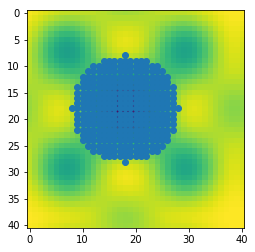

In [242]:
plt.imshow(np.sum(np.sum(result,axis=2),axis=2))
plt.scatter(col_list,row_list)